In [1]:
from pathlib import Path

ROOT = Path(globals()['__vsc_ipynb_file__']).parent.parent
print(ROOT)

import sys
sys.path.append(str(ROOT))

/Users/gabrieleagliardi/Documents/GitHub/Client-Vanguard-Optimization


In [2]:
from qiskit import qpy
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [3]:
from src.step_1 import build_ansatz, get_backend

In [4]:
num_vars = 109
instance = 'vanguard/internal/default'

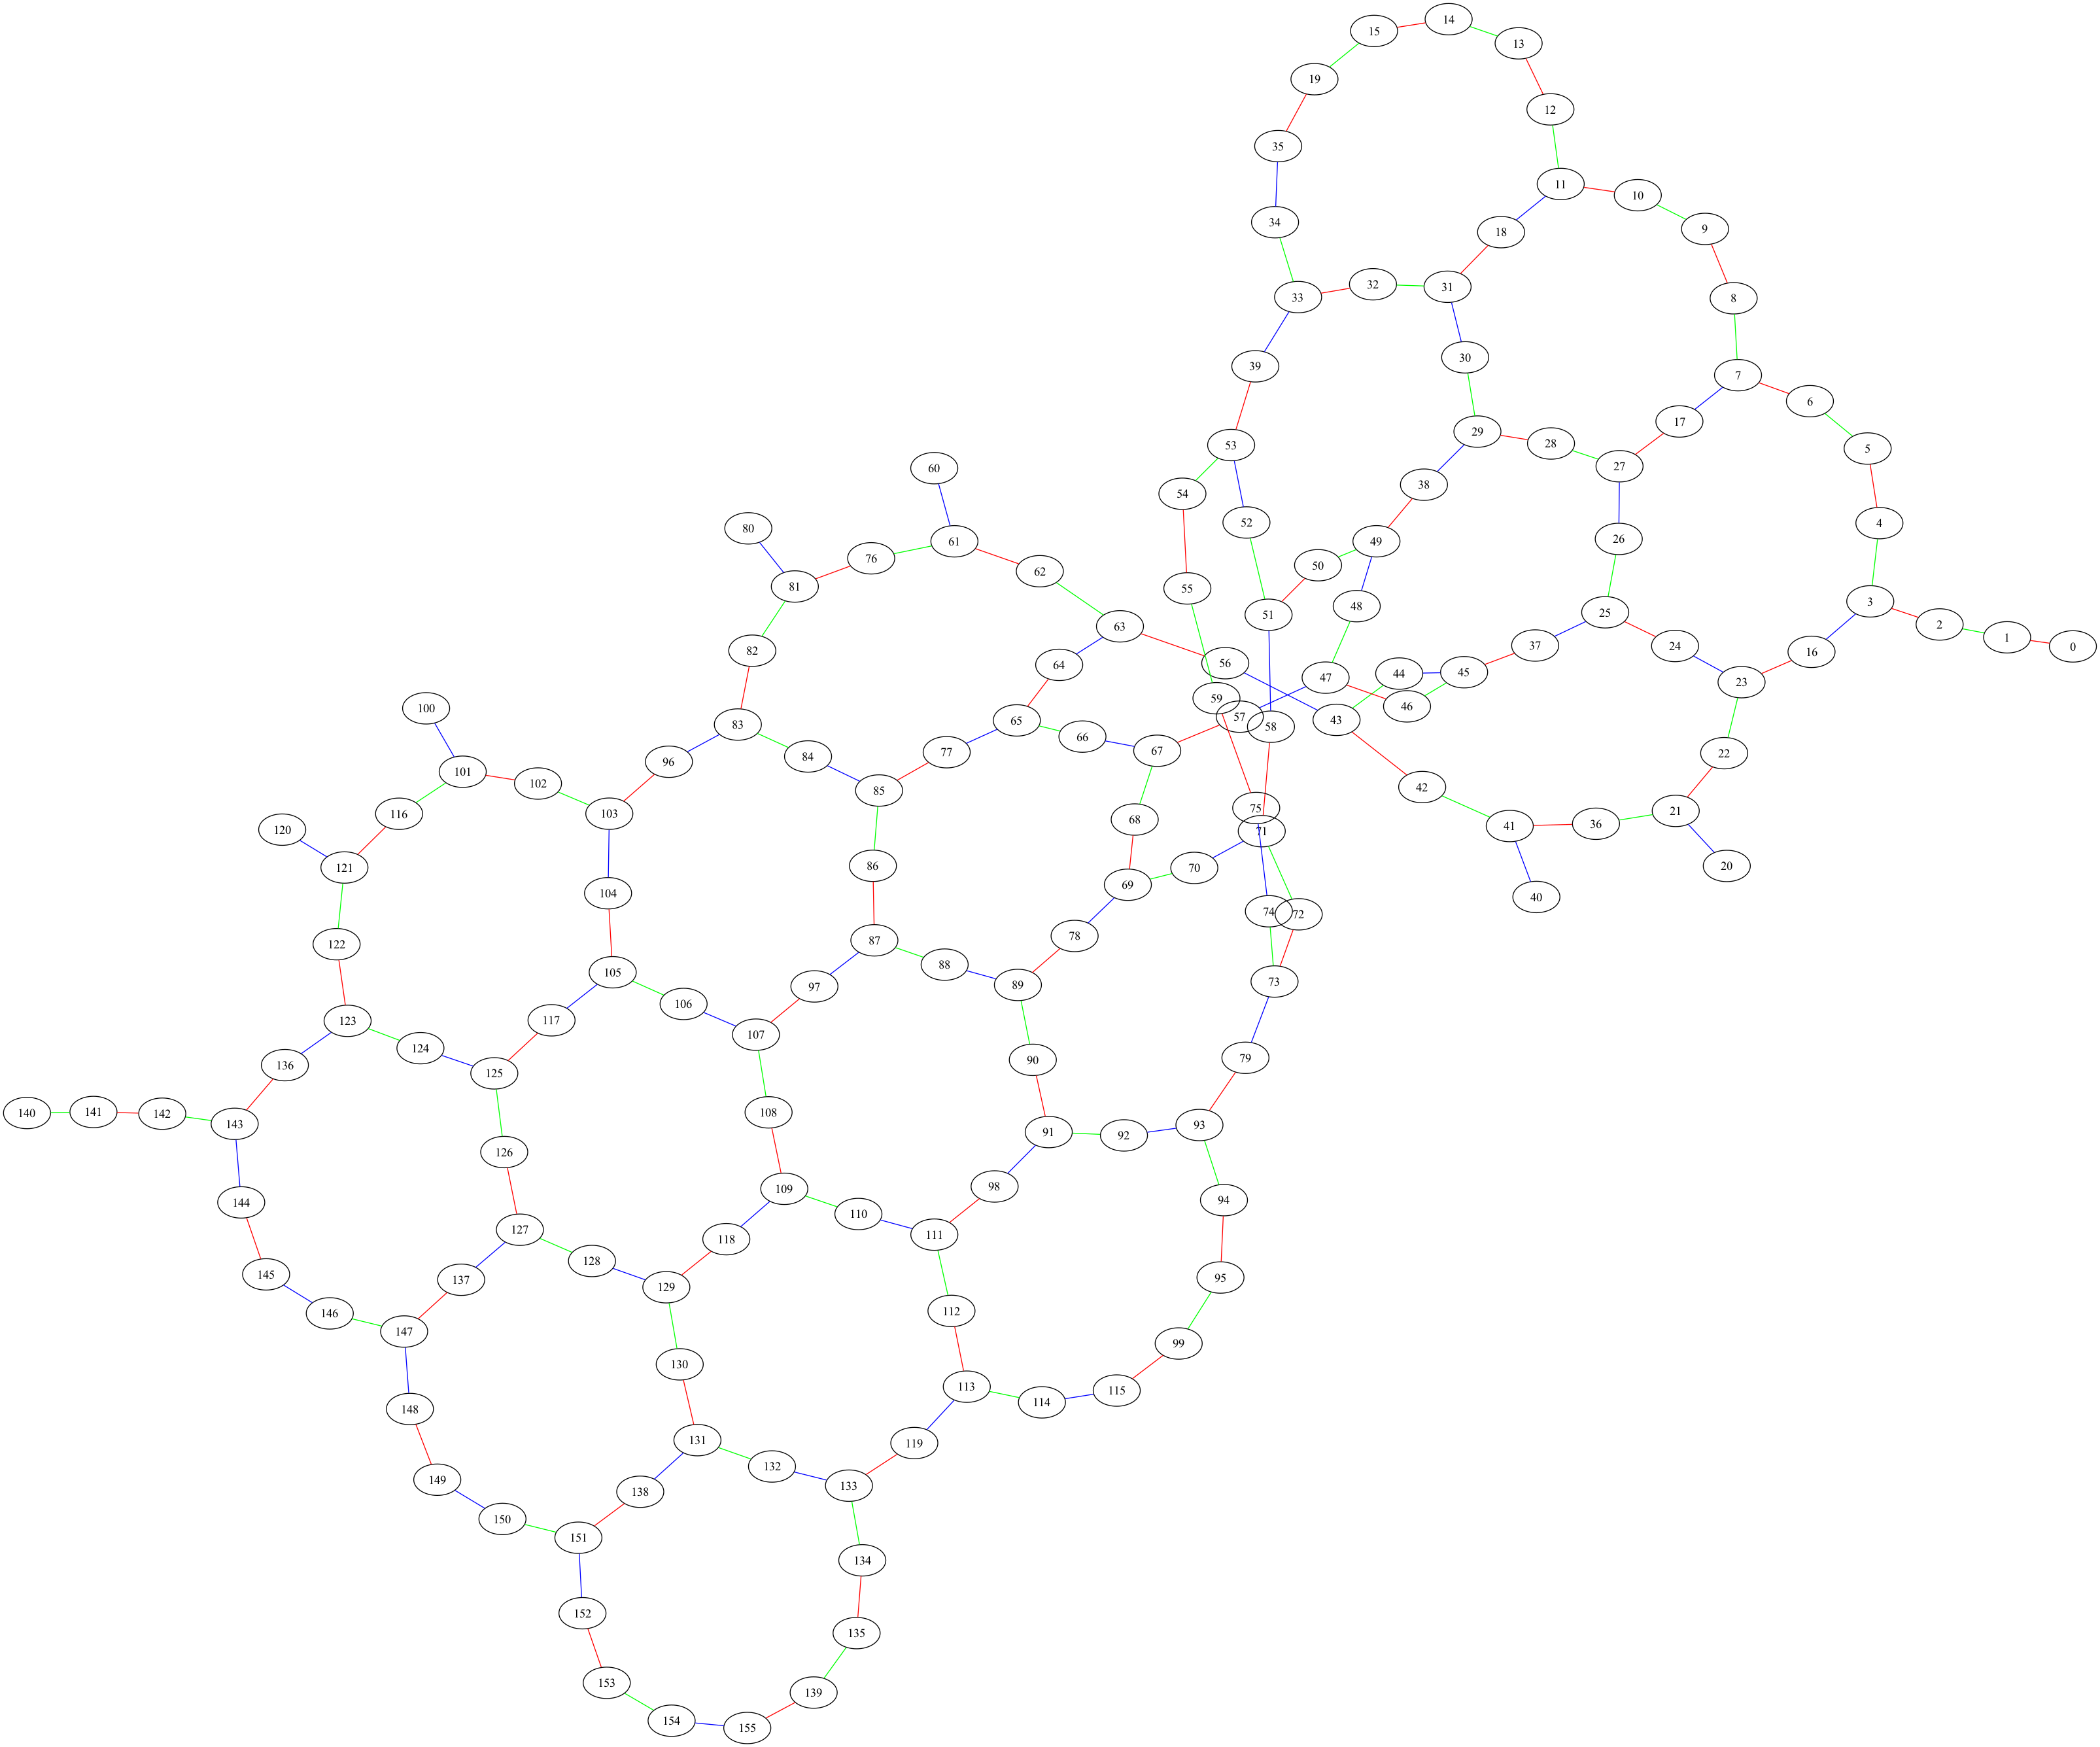

In [5]:
backend = get_backend('ibm_marrakesh', instance, num_vars)

from qiskit_addon_utils.coloring import auto_color_edges

coloring: dict = auto_color_edges([(i,j) for i,j in backend.coupling_map if i<j])

from rustworkx import PyDiGraph, PyGraph
topology = PyGraph()
topology.extend_from_weighted_edge_list(
    [(source, target, color) for ((source, target), color) in coloring.items()]
)

def color_edge(edge):
    color_dict = {0: "red", 1: "green", 2: "blue", 3:'yellow', 4:'purple', 5:'black'}
    return {"color": color_dict[edge]}

from rustworkx.visualization import graphviz_draw
graphviz_draw(topology, edge_attr_fn=color_edge, method="neato")

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14], [0, 15], [-1, 3], [-1, 7], [-1, 11], [-1, 15], [-2, 0], [-2, 1], [-2, 2], [-2, 3], [-2, 4], [-2, 5], [-2, 6], [-2, 7], [-2, 8], [-2, 9], [-2, 10], [-2, 11], [-2, 12], [-2, 13], [-2, 14], [-2, 15], [-3, 1], [-3, 5], [-3, 9], [-3, 13], [-4, 0], [-4, 1], [-4, 2], [-4, 3], [-4, 4], [-4, 5], [-4, 6], [-4, 7], [-4, 8], [-4, 9], [-4, 10], [-4, 11], [-4, 12], [-4, 13], [-4, 14], [-4, 15], [-5, 3], [-5, 7], [-5, 11], [-5, 15], [-6, 0], [-6, 1], [-6, 2], [-6, 3], [-6, 4], [-6, 5], [-6, 6], [-6, 7], [-6, 8], [-6, 9], [-6, 10], [-6, 11], [-6, 12], [-6, 13], [-6, 14], [-6, 15], [-7, 1], [-7, 5], [-7, 9], [-7, 13], [-8, 0], [-8, 1], [-8, 2], [-8, 3], [-8, 4], [-8, 5], [-8, 6], [-8, 7], [-8, 8], [-8, 9], [-8, 10], [-8, 11], [-8, 12], [-8, 13], [-8, 14], [-8, 15], [-9, 3], [-9, 7], [-9, 11], [-9, 15], [-10, 0], [-10, 1], [-10, 2], [-10, 3], [-10, 4], [-10, 5], [-10, 6], [-10, 7

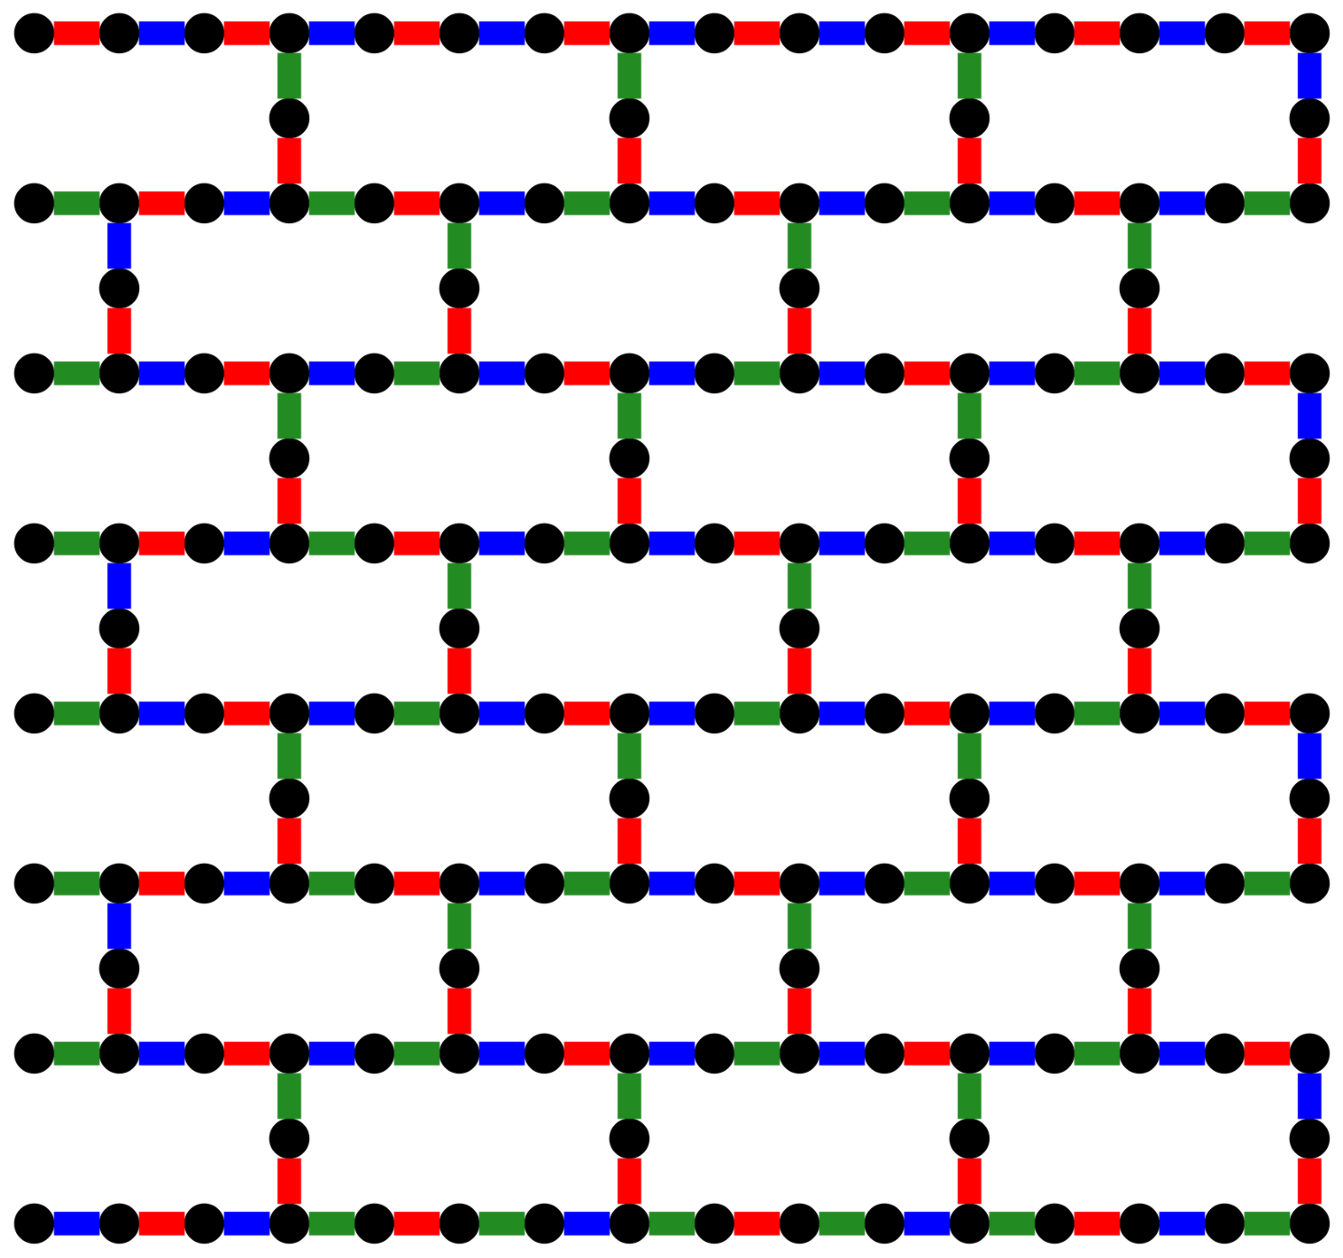

In [6]:
from qiskit.visualization import plot_coupling_map
from qiskit_ibm_runtime.utils import Embedding

coupling_map = backend.coupling_map
color_dict = {0: "red", 1: "blue", 2: "forestgreen"}

coord = [[-0, i] for i in range(16)]+\
        [[-1, 4*i+3] for i in range(4)]+\
        [[-2, i] for i in range(16)]+\
        [[-3, 4*i+1] for i in range(4)]+\
        [[-4, i] for i in range(16)]+\
        [[-5, 4*i+3] for i in range(4)]+\
        [[-6, i] for i in range(16)]+\
        [[-7, 4*i+1] for i in range(4)]+\
        [[-8, i] for i in range(16)]+\
        [[-9, 4*i+3] for i in range(4)]+\
        [[-10, i] for i in range(16)]+\
        [[-11, 4*i+1] for i in range(4)]+\
        [[-12, i] for i in range(16)]+\
        [[-13, 4*i+3] for i in range(4)]+\
        [[-14, i] for i in range(16)]

print(coord)

plot_coupling_map(
    coupling_map.size(),
    qubit_coordinates=coord,
    coupling_map=list(coloring.keys()),
    line_color=[color_dict[v] for v in coloring.values()],
    label_qubits=False,
    qubit_color=['black']*coupling_map.size(),
    qubit_size=40,
    line_width=20
)

In [7]:
outputs = []

for device in ['ibm_marrakesh']:
    backend = get_backend(device, instance, num_vars)
    for ansatz in ['bfcdR']:
        for reps in [1,2,3]:
            ansatz_params = {'entanglement': ('color' if backend.coupling_map.is_symmetric else 'di-color'), 'reps':reps}
            ansatz_, initial_layout = build_ansatz(ansatz, ansatz_params, num_vars, backend)
            for use_init_layout in [True, False]:

                # step_2 CIRCUIT OPTIMIZATION
                for trial in range(10):
                    print(device, ansatz, reps, trial)
                    out_path = f'{ROOT}/data/transpilation/{ansatz_params["entanglement"]}/{num_vars}_pm_{device}_{ansatz}_{reps}_{use_init_layout}_{trial}.qpy'
                    if Path(out_path).is_file():
                        with open(out_path, 'br') as f:
                            isa_ansatz = qpy.load(f)[0]
                    else:
                        isa_ansatz = generate_preset_pass_manager(target=backend.target, optimization_level=3, initial_layout=initial_layout if use_init_layout else None).run(ansatz_)
                        with open(out_path, 'bw') as f:
                            qpy.dump(isa_ansatz, f)
                    outputs.append({'ansatz': ansatz, 'reps': reps, 'device': device, 'trial': trial, 'use_init_layout': use_init_layout,
                                    'depth': isa_ansatz.depth(),
                                    '2q-depth': isa_ansatz.depth(lambda x:x.operation.num_qubits==2),
                                    'count_ops': isa_ansatz.count_ops(),
                                    })

ibm_marrakesh bfcdR 1 0
ibm_marrakesh bfcdR 1 1
ibm_marrakesh bfcdR 1 2
ibm_marrakesh bfcdR 1 3
ibm_marrakesh bfcdR 1 4
ibm_marrakesh bfcdR 1 5
ibm_marrakesh bfcdR 1 6
ibm_marrakesh bfcdR 1 7
ibm_marrakesh bfcdR 1 8
ibm_marrakesh bfcdR 1 9
ibm_marrakesh bfcdR 1 0
ibm_marrakesh bfcdR 1 1
ibm_marrakesh bfcdR 1 2
ibm_marrakesh bfcdR 1 3
ibm_marrakesh bfcdR 1 4
ibm_marrakesh bfcdR 1 5
ibm_marrakesh bfcdR 1 6
ibm_marrakesh bfcdR 1 7
ibm_marrakesh bfcdR 1 8
ibm_marrakesh bfcdR 1 9
ibm_marrakesh bfcdR 2 0
ibm_marrakesh bfcdR 2 1
ibm_marrakesh bfcdR 2 2
ibm_marrakesh bfcdR 2 3
ibm_marrakesh bfcdR 2 4
ibm_marrakesh bfcdR 2 5
ibm_marrakesh bfcdR 2 6
ibm_marrakesh bfcdR 2 7
ibm_marrakesh bfcdR 2 8
ibm_marrakesh bfcdR 2 9
ibm_marrakesh bfcdR 2 0
ibm_marrakesh bfcdR 2 1
ibm_marrakesh bfcdR 2 2
ibm_marrakesh bfcdR 2 3
ibm_marrakesh bfcdR 2 4
ibm_marrakesh bfcdR 2 5
ibm_marrakesh bfcdR 2 6
ibm_marrakesh bfcdR 2 7
ibm_marrakesh bfcdR 2 8
ibm_marrakesh bfcdR 2 9
ibm_marrakesh bfcdR 3 0
ibm_marrakesh bf

In [8]:
import pandas as pd

df_passmanager = pd.DataFrame(outputs)
df_passmanager

,ansatz,reps,device,trial,use_init_layout,depth,2q-depth,count_ops
0,bfcdR,1,ibm_marrakesh,0,True,42,9,"{'sx': 1096, 'rz': 969, 'cz': 369, 'measure': ..."
1,bfcdR,1,ibm_marrakesh,1,True,42,9,"{'sx': 1096, 'rz': 969, 'cz': 369, 'measure': ..."
2,bfcdR,1,ibm_marrakesh,2,True,42,9,"{'sx': 1096, 'rz': 969, 'cz': 369, 'measure': ..."
3,bfcdR,1,ibm_marrakesh,3,True,42,9,"{'sx': 1096, 'rz': 969, 'cz': 369, 'measure': ..."
4,bfcdR,1,ibm_marrakesh,4,True,42,9,"{'sx': 1096, 'rz': 969, 'cz': 369, 'measure': ..."
5,bfcdR,1,ibm_marrakesh,5,True,42,9,"{'sx': 1096, 'rz': 969, 'cz': 369, 'measure': ..."
6,bfcdR,1,ibm_marrakesh,6,True,42,9,"{'sx': 1096, 'rz': 969, 'cz': 369, 'measure': ..."
7,bfcdR,1,ibm_marrakesh,7,True,42,9,"{'sx': 1096, 'rz': 969, 'cz': 369, 'measure': ..."
8,bfcdR,1,ibm_marrakesh,8,True,42,9,"{'sx': 1096, 'rz': 969, 'cz': 369, 'measure': ..."
9,bfcdR,1,ibm_marrakesh,9,True,42,9,"{'sx': 1096, 'rz': 969, 'cz': 369, 'measure': ..."


In [10]:
from qiskit_ibm_transpiler.transpiler_service import TranspilerService
outputs = []

for device in ['ibm_marrakesh']:
    cloud_transpiler_service = TranspilerService(
        backend_name=device,
        ai=True,
        optimization_level=3,
    )
    backend = get_backend(device, instance, num_vars)
    for ansatz in ['bfcdR']:
        for reps in [1,2,3]:
            ansatz_params = {'entanglement': ('color' if backend.coupling_map.is_symmetric else 'di-color'), 'reps':reps}
            ansatz_, _ = build_ansatz(ansatz, ansatz_params, num_vars, backend)

            # step_2 CIRCUIT OPTIMIZATION
            for trial in range(10):
                out_path = f'{ROOT}/data/transpilation/{ansatz_params["entanglement"]}/{num_vars}_ai_{device}_{ansatz}_{reps}_{trial}.qpy'
                print(device, ansatz, reps, trial)
                if Path(out_path).is_file():
                    with open(out_path, 'br') as f:
                        isa_ansatz = qpy.load(f)[0]
                else:
                    isa_ansatz = cloud_transpiler_service.run(ansatz_)
                    with open(out_path, 'bw') as f:
                        qpy.dump(isa_ansatz, f)
                    outputs.append({'ansatz': ansatz, 'reps': reps, 'device': device, 'trial': trial,
                                'depth': isa_ansatz.depth(),
                                '2q-depth': isa_ansatz.depth(lambda x:x.operation.num_qubits==2),
                                'count_ops': isa_ansatz.count_ops()
                                })


ibm_marrakesh bfcdR 1 0
ibm_marrakesh bfcdR 1 1
ibm_marrakesh bfcdR 1 2
ibm_marrakesh bfcdR 1 3
ibm_marrakesh bfcdR 1 4
ibm_marrakesh bfcdR 1 5
ibm_marrakesh bfcdR 1 6
ibm_marrakesh bfcdR 1 7
ibm_marrakesh bfcdR 1 8
ibm_marrakesh bfcdR 1 9
ibm_marrakesh bfcdR 2 0
ibm_marrakesh bfcdR 2 1
ibm_marrakesh bfcdR 2 2
ibm_marrakesh bfcdR 2 3
ibm_marrakesh bfcdR 2 4
ibm_marrakesh bfcdR 2 5
ibm_marrakesh bfcdR 2 6
ibm_marrakesh bfcdR 2 7
ibm_marrakesh bfcdR 2 8
ibm_marrakesh bfcdR 2 9
ibm_marrakesh bfcdR 3 0
ibm_marrakesh bfcdR 3 1
ibm_marrakesh bfcdR 3 2
ibm_marrakesh bfcdR 3 3
ibm_marrakesh bfcdR 3 4
ibm_marrakesh bfcdR 3 5
ibm_marrakesh bfcdR 3 6
ibm_marrakesh bfcdR 3 7
ibm_marrakesh bfcdR 3 8
ibm_marrakesh bfcdR 3 9


In [11]:
df_ai = pd.DataFrame(outputs)
df_ai

""


<Axes: xlabel='2q-ops', ylabel='x'>

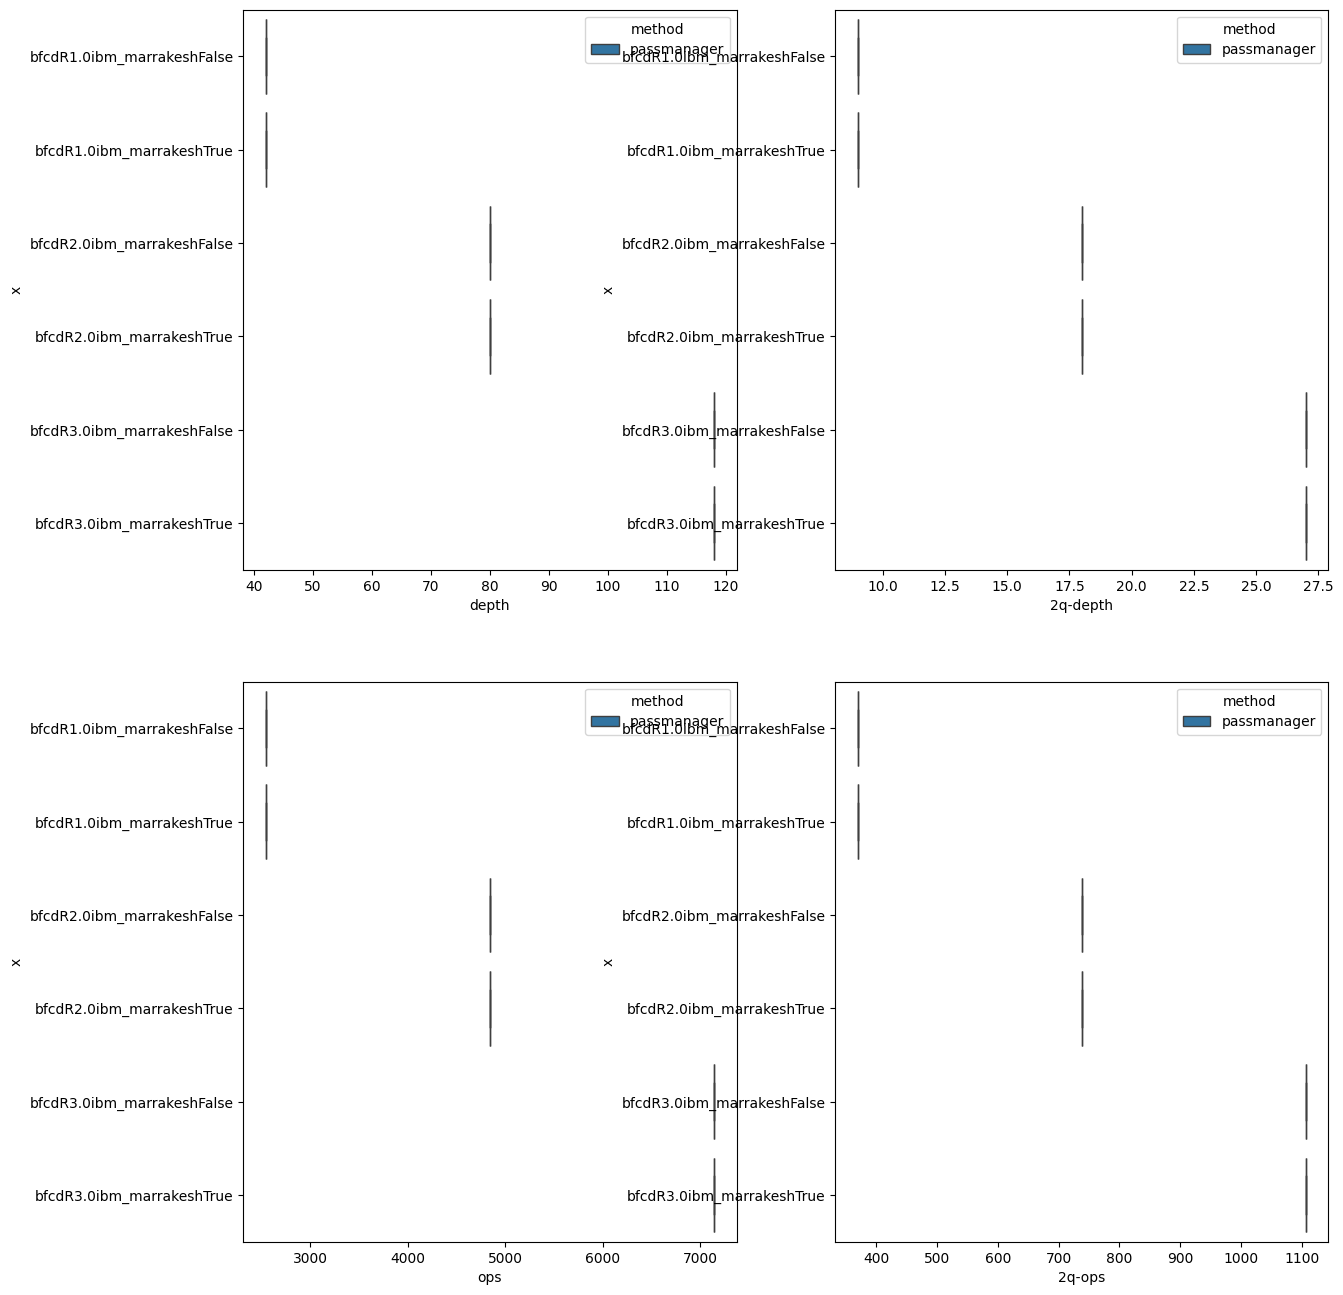

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt


df_passmanager['method'] = 'passmanager'
df_ai['method'] = 'ai'

df = pd.concat([df_passmanager, df_ai])
df['x']=df['ansatz'] + df['reps'].apply(str) + df['device'] + df['use_init_layout'].apply(str)
df['ops'] = df.count_ops.apply(lambda x: sum(x.values()))
df['2q-ops'] = df.count_ops.apply(lambda x: sum(v for k,v in x.items() if k in ['cz', 'ecr']))
df.sort_values(['x'], inplace=True)

_, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(14,16))
sns.boxplot(df[['x','depth','method']], y='x', x='depth', hue='method', ax=ax1)
# ax1.set_title('depth')
sns.boxplot(df[['x','2q-depth','method']], y='x', x='2q-depth', hue='method', ax=ax2)
# ax2.set_title('2q-depth')
sns.boxplot(df[['x','ops','method']], y='x', x='ops', hue='method', ax=ax3)
# ax3.set_title('ops')
sns.boxplot(df[['x','2q-ops','method']], y='x', x='2q-ops', hue='method', ax=ax4)
# ax4.set_title('2q-ops')